<a href="https://colab.research.google.com/github/denisecammarota/d2ai-notes/blob/main/ch8_d2ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn.utils as utils

In [2]:
import os
import hashlib
import urllib.request

In [3]:
import re

# Linear Regression with a lookback window

### Defining our linear regression

In [4]:
class LinearRegression(nn.Module):

  def __init__(self):
      super().__init__()
      self.linear = nn.LazyLinear(out_features = 1)

  def forward(self, x):
    return self.linear(x)

### Generating our data

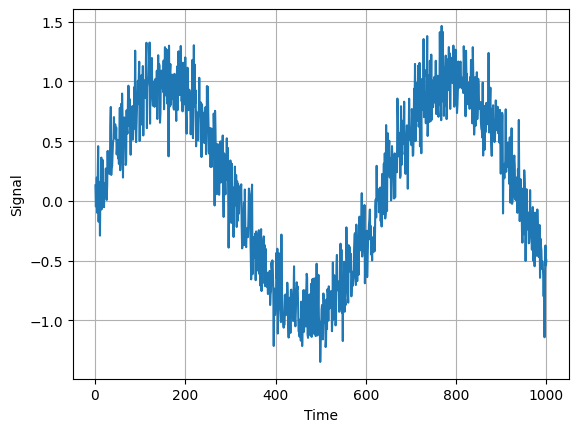

In [5]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.randn(T) * 0.2
plt.plot(time, x)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.grid()
plt.show()

### Generating Markov dataset for training and testing

In [6]:
tau = 4
num_train = 600
train = True
features = [x[i : T-tau+i] for i in range(tau)]
features = torch.stack(features, 1)
labels = x[tau:].reshape((-1, 1))
X_train = features[:num_train,:]
X_test = features[num_train:,:]
y_train = labels[:num_train]
y_test = labels[num_train:]

In [7]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [8]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

### Training the model

In [9]:
model = LinearRegression()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

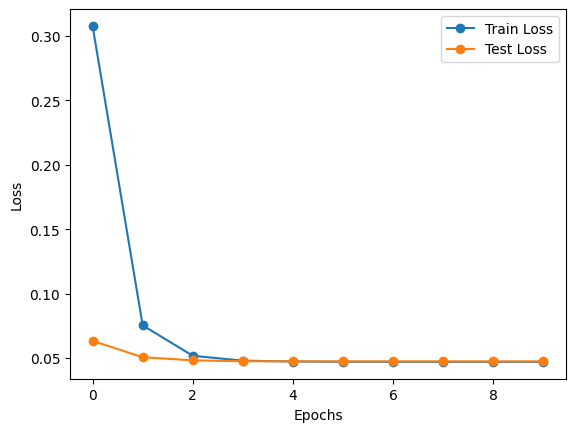

In [10]:
n_epochs = 10
train_loss = []
test_loss = []

for epoch in range(n_epochs):
  train_aux = 0
  test_aux = 0

  # training mode for model
  model.train()
  for batch_X, batch_y in train_loader:
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    train_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
  train_loss.append(train_aux/len(train_dataset)) # / number of training dataset

  # test mode for model
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      output = model(batch_X)
      loss = criterion(output, batch_y)
      predicted_label = output.argmax(dim = 1)
      test_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
    test_loss.append(test_aux/len(test_dataset)) # / number of testing dataset


plt.plot(range(n_epochs), train_loss, '-o', label = 'Train Loss')
plt.plot(range(n_epochs), test_loss, '-o', label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Doing prediction on our timeseries

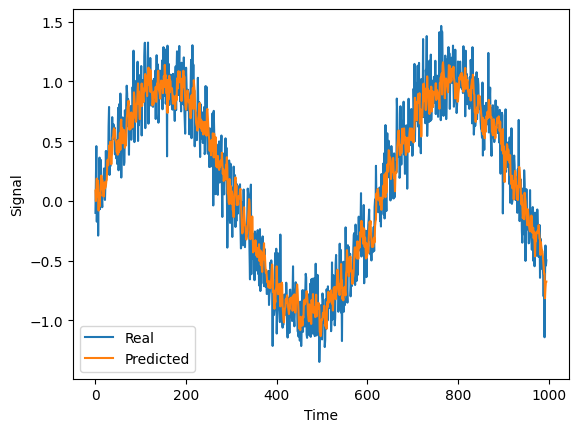

In [11]:
y_pred = model(features)
plt.plot(labels, label = 'Real')
plt.plot(y_pred.detach().numpy(), label = 'Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()

### Doing multi-step prediction

In [12]:
multistep_preds = torch.zeros(T)
multistep_preds[:] = x

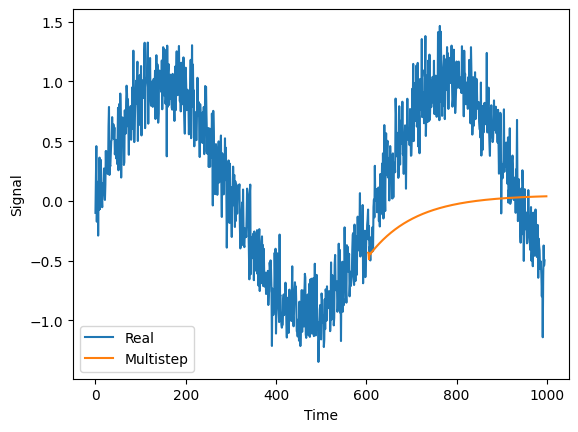

In [13]:
multistep_preds = torch.zeros(T)
multistep_preds[:] = x

for i in range(num_train + tau, T):
  #print(multistep_preds[i - tau:i].reshape((1, -1)))
  multistep_preds[i] = model(
        multistep_preds[i - tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

plt.plot(labels, label = 'Real')
plt.plot(np.arange(num_train + tau, T, 1), multistep_preds[num_train + tau:], label = 'Multistep')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.show()

# Playing with text data

### Dowloading data

In [14]:
DATA_URL = "https://d2l-data.s3-accelerate.amazonaws.com/"
FILENAME = "timemachine.txt"
SHA1 = "090b5e7e70c295757f55df93cb0a180b9691891a"

def download(url, root="data", filename=FILENAME, sha1_hash=None):
    os.makedirs(root, exist_ok=True)
    path = os.path.join(root, filename)

    if os.path.exists(path):
        if sha1_hash:
            sha1 = hashlib.sha1(open(path, "rb").read()).hexdigest()
            if sha1 == sha1_hash:
                return path
        else:
            return path

    print("Downloading...")
    urllib.request.urlretrieve(url + filename, path)

    if sha1_hash:
        sha1 = hashlib.sha1(open(path, "rb").read()).hexdigest()
        assert sha1 == sha1_hash, "SHA-1 mismatch!"

    return path

fname = download(DATA_URL, sha1_hash=SHA1)

with open(fname, "r", encoding="utf-8") as f:
    raw_text = f.read()

raw_text[:60]

Downloading...


'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

### Removing ponctuation

In [15]:
def preprocess(text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

In [16]:
text = preprocess(raw_text)

In [17]:
text[:60]

'the time machine by h g wells i the time traveller for so it'

### Tokenizing

In [18]:
def tokenize(text):
    return list(text)

In [19]:
tokens = tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

### Creating vocabulary

In [20]:
import collections

In [21]:
class Vocab:

  def __init__(self, tokens = [], min_freq = 0, reserved_tokens = []):
    # Flatten a 2d list if needed with a lambda function
    if tokens and isinstance(tokens[0], list):
      tokens = [token for line in tokens for token in line]
    # Count token frequencies using the collections package from base Python
    counter = collections.Counter(tokens)
    self.token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse = True)
    # The list of unique tokens - constructing dictionaries
    self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

  def __len__(self):
    return len(self.idx_to_token)

  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if hasattr(indices, '__len__') and len(indices) > 1:
      return [self.idx_to_token[int(index)] for index in indices]
    return self.idx_to_token[indices]

  @property
  def unk(self):
    return self.token_to_idx['<unk>']


In [22]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


## Creating a corpus

I am doing this in base python, so just adding the corpus, we already have the vocabulary

In [23]:
corpus = [vocab[token] for token in tokens]
corpus

[21,
 9,
 6,
 0,
 21,
 10,
 14,
 6,
 0,
 14,
 2,
 4,
 9,
 10,
 15,
 6,
 0,
 3,
 26,
 0,
 9,
 0,
 8,
 0,
 24,
 6,
 13,
 13,
 20,
 0,
 10,
 0,
 21,
 9,
 6,
 0,
 21,
 10,
 14,
 6,
 0,
 21,
 19,
 2,
 23,
 6,
 13,
 13,
 6,
 19,
 0,
 7,
 16,
 19,
 0,
 20,
 16,
 0,
 10,
 21,
 0,
 24,
 10,
 13,
 13,
 0,
 3,
 6,
 0,
 4,
 16,
 15,
 23,
 6,
 15,
 10,
 6,
 15,
 21,
 0,
 21,
 16,
 0,
 20,
 17,
 6,
 2,
 12,
 0,
 16,
 7,
 0,
 9,
 10,
 14,
 0,
 24,
 2,
 20,
 0,
 6,
 25,
 17,
 16,
 22,
 15,
 5,
 10,
 15,
 8,
 0,
 2,
 0,
 19,
 6,
 4,
 16,
 15,
 5,
 10,
 21,
 6,
 0,
 14,
 2,
 21,
 21,
 6,
 19,
 0,
 21,
 16,
 0,
 22,
 20,
 0,
 9,
 10,
 20,
 0,
 8,
 19,
 6,
 26,
 0,
 6,
 26,
 6,
 20,
 0,
 20,
 9,
 16,
 15,
 6,
 0,
 2,
 15,
 5,
 0,
 21,
 24,
 10,
 15,
 12,
 13,
 6,
 5,
 0,
 2,
 15,
 5,
 0,
 9,
 10,
 20,
 0,
 22,
 20,
 22,
 2,
 13,
 13,
 26,
 0,
 17,
 2,
 13,
 6,
 0,
 7,
 2,
 4,
 6,
 0,
 24,
 2,
 20,
 0,
 7,
 13,
 22,
 20,
 9,
 6,
 5,
 0,
 2,
 15,
 5,
 0,
 2,
 15,
 10,
 14,
 2,
 21,
 6,
 5,
 0,
 21,
 9,
 6,


## Counting the number of tokens and corpus size

In [24]:
len(corpus)

173428

In [25]:
len(vocab)

28

## Exploratory Language Statistics

In [26]:
words = text.split()

In [27]:
vocab = Vocab(words)

In [28]:
vocab.token_freqs[:10] # Calculating the most frequent words

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

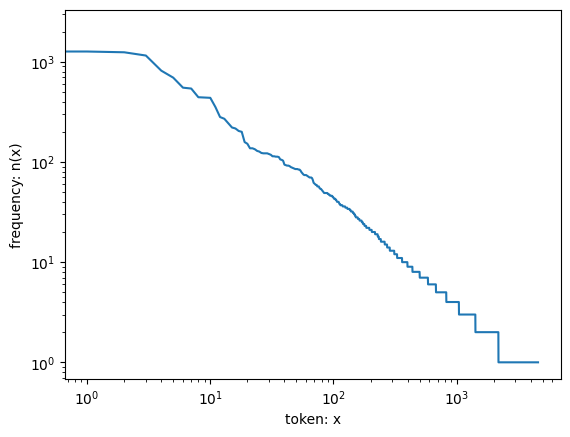

In [29]:
freqs = [freq for token, freq in vocab.token_freqs]
plt.plot(freqs)
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [30]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [31]:
trigram_tokens = ['--'.join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

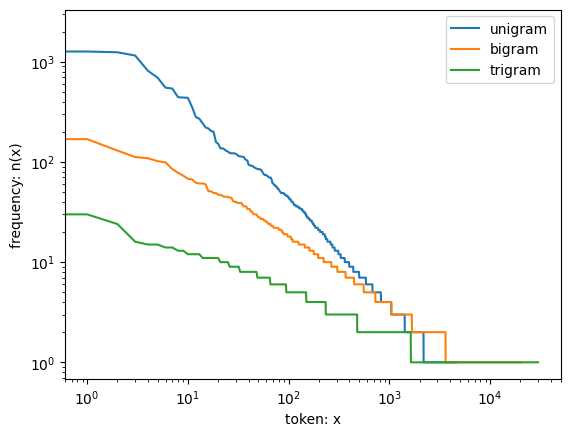

In [32]:
freqs = [freq for token, freq in vocab.token_freqs]
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
plt.plot(freqs, label = 'unigram')
plt.plot(bigram_freqs, label = 'bigram')
plt.plot(trigram_freqs, label = 'trigram')
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

# Recurrent Neural Networks - RNNs

## Loading the Time Machine Dataset

In [33]:
class TimeMachine():

  def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000, root = 'data'):
    #super(self).__init__()
    #self.save_hyperparameters()
    self.batch_size = batch_size
    self.num_steps = num_steps
    self.num_train = num_train
    self.num_val = num_val
    self.root = root

    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1]
                          for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

  def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    dataset = TensorDataset(self.X[idx], self.Y[idx])
    return DataLoader(dataset,
                      batch_size = self.batch_size,
                      shuffle = train)

  def _download(self):
        return open(download(DATA_URL, root=self.root, sha1_hash=SHA1), encoding="utf-8").read()

  def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

  def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

  def _tokenize(self, text):
    return list(text)

In [34]:
data = TimeMachine(batch_size=1024, num_steps=32)

In [35]:
train_loader = data.get_dataloader(train = True)
test_loader = data.get_dataloader(train = False)

## Defining a single RNN layer

In [36]:
class RNN(nn.Module):

  def __init__(self, num_inputs, num_hiddens):
    super().__init__()
    self.rnn = nn.RNN(num_inputs, num_hiddens)
    self.num_inputs = num_inputs
    self.num_hiddens = num_hiddens

  def forward(self, inputs, H = None):
    return self.rnn(inputs, H)

## Defining the RNN network from it

In [37]:
class RNNMLScratch(nn.Module):

    def __init__(self, vocab_size, num_hiddens, sigma=0.01):

        super().__init__()
        self.vocab_size = vocab_size # size of the corpus
        self.num_hiddens = num_hiddens # hidden state size

        self.rnn = nn.RNN(vocab_size, num_hiddens) # the rnn itself

        self.output = nn.Linear(num_hiddens, vocab_size)

        nn.init.normal_(self.output.weight, std = sigma)
        nn.init.zeros_(self.output.bias)

    def one_hot(self, X):
        return F.one_hot(X.T.long(), self.vocab_size).float()

    def forward(self, X, state=None):

        # do one hot encoding
        embs = self.one_hot(X)

        # initialize state if it is beginning of a sequence
        # shape = (num_layers, batch_size, num_hiddens)
        if state is None:
            state = torch.zeros(
                (1, X.shape[0], self.num_hiddens),
                device=X.device)

        # forward pass through RNN
        # outputs shape: (steps, batch, hidden)
        outputs, state = self.rnn(embs, state)

        # project output to vocabulary size
        # from (steps*batch, hidden) ----> (steps*batch, vocab)
        reshaped_outputs = outputs.view(-1, outputs.shape[-1])
        y = self.output(reshaped_outputs)

        # reshape back to (step, batch, vocab)
        return y.view(outputs.shape[0], outputs.shape[1], -1), state

## Training and predicting

In [47]:
model = RNNMLScratch(vocab_size = len(data.vocab), num_hiddens = 32)

In [48]:
criterion = nn.CrossEntropyLoss() # includes softmax classifier
optimizer = optim.Adam(model.parameters(), lr = 0.01)
n_epochs = 100
train_loss = []
test_loss = []
test_accuracy = []
device = 'cpu'

for epoch in range(n_epochs):
  model.train()
  train_aux = 0
  train_items = 0
  state = None

  for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    optimizer.zero_grad()

    # forward pass (output, shape)
    # output shape: (steps, batch, vocab)
    output, state = model(batch_X)

    # reshape for crossentropyloss
    # expects (N, C) where N = batch*steps, C = vocabulary size
    output_flattened = output.view(-1, model.vocab_size)
    targets_flattened = batch_y.T.reshape(-1).long()
    loss = criterion(output_flattened, targets_flattened)

    # backward pass
    loss.backward()

    # gradient clipping
    utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()

    state = state.detach()

    train_aux += loss.item() * batch_X.size(0)
    train_items += batch_X.shape[0]

  train_loss.append(train_aux/train_items)

  model.eval()
  test_aux = 0
  test_items = 0
  total_correct = 0
  total_tokens = 0

  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      output, _ = model(batch_X)

      output_flattened = output.view(-1, model.vocab_size)
      targets_flattened = batch_y.T.reshape(-1).long()

      loss = criterion(output_flattened, targets_flattened)

      predicted_labels = output_flattened.argmax(dim = 1)
      total_correct += (predicted_labels == targets_flattened).sum().item()
      total_tokens += targets_flattened.numel()

      test_aux += loss.item() * batch_X.shape[0]
      test_items += batch_X.shape[0]

  test_accuracy.append(total_correct / total_tokens)
  test_loss.append(test_aux / test_items)

  if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}")



Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Epoch 50
Epoch 55
Epoch 60
Epoch 65
Epoch 70
Epoch 75
Epoch 80
Epoch 85
Epoch 90
Epoch 95
Epoch 100


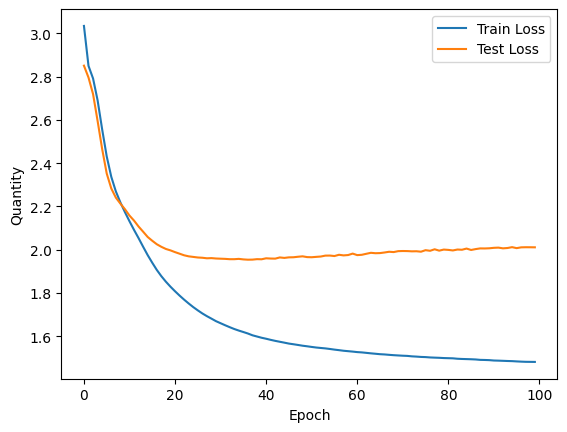

In [49]:
plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss, label = 'Test Loss')
#plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Quantity')
plt.show()

In [50]:
test_accuracy

[0.18783125,
 0.18783125,
 0.18783125,
 0.21021875,
 0.30755,
 0.331275,
 0.33331875,
 0.336825,
 0.3491,
 0.3571625,
 0.35680625,
 0.364175,
 0.3729,
 0.382425,
 0.39668125,
 0.40355625,
 0.4105625,
 0.417175,
 0.41921875,
 0.42025625,
 0.424075,
 0.425175,
 0.42856875,
 0.4302125,
 0.4341,
 0.4342,
 0.4332625,
 0.4341875,
 0.4379875,
 0.43896875,
 0.4432875,
 0.4444875,
 0.44799375,
 0.45045,
 0.450575,
 0.4534125,
 0.45233125,
 0.45700625,
 0.45471875,
 0.45775,
 0.45650625,
 0.45783125,
 0.45580625,
 0.45829375,
 0.45749375,
 0.4579,
 0.4597375,
 0.45735,
 0.45798125,
 0.4613,
 0.46170625,
 0.46161875,
 0.4609625,
 0.46095,
 0.46150625,
 0.46205,
 0.4607875,
 0.4607,
 0.45898125,
 0.45780625,
 0.46026875,
 0.4581625,
 0.456825,
 0.4546375,
 0.4552625,
 0.45781875,
 0.45645,
 0.45765625,
 0.4571375,
 0.4580875,
 0.45815625,
 0.45845,
 0.4589,
 0.45993125,
 0.4573125,
 0.45783125,
 0.45664375,
 0.455375,
 0.45605,
 0.454975,
 0.45555,
 0.457125,
 0.45643125,
 0.45705625,
 0.4549,
 0.

# Bonus: some more lessons on the character RNNs

I struggled a lot to implement my own RNNMLScratch without any d2l package functionality and to make it work. Therefore, going forward in the book, I wanted to see a different implementation of character RNN and I chose the one based from Raschka's videos:
- https://www.youtube.com/watch?v=fSBw6TrePPg
- https://www.youtube.com/watch?v=PFcWQkGP4lU
- https://www.youtube.com/watch?v=tL5puCeDr-o

It is also interesting to see the use of the embedding layer in this different implementation as extra learning, for example.
This uses an LSTM, but it is analogous to use a simple RNN.

Another interesting implementation is shown in: https://github.com/nikhilbarhate99/Char-RNN-PyTorch


